В данном ноутбуке реализовано решение задачи классификации эмоций по аудиозаписям датасета RAVDESS.
Почти вся работа велась на платформе Kaggle. Поэтому для воспроизведения результатов необходимо изменить пути к данным и весам.

# Библиотеки

In [34]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy

import torch
import torch.nn as nn
import torchaudio
import torchaudio.functional as F
from torch.utils.tensorboard import SummaryWriter

import librosa

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from IPython.display import clear_output, Audio

!pip install torcheval
from torcheval.metrics.functional import multiclass_accuracy

!pip install opensmile
import opensmile

!pip install audiomentations
from audiomentations import PitchShift

# Предобработка данных

Название каждого файла состоит из 7 идентификаторов:

- Modality (01 = full-AV, 02 = video-only, **03 = audio-only**). NOTE: Audio-only subset
- Vocal channel (**01 = speech**, 02 = song). NOTE: Speech subset
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised). NOTE: Num will be shifted by -1 for future target
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Sample rate был установлен на уровне 16 кГц, чтобы соответствовать модели Wav2Vec2.0 \
Метки классов были сдвинуты на -1 относительно указанных в названии

In [35]:
SR = 16_000

num_to_emotion = {
    0: 'neutral', 1: 'calm',
    2: 'happy', 3: 'sad',
    4: 'angry', 5: 'fearful',
    6: 'disgust', 7: 'surprised'
}

path = '/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24'
#path = check_path = 'ENTER YOUR PATH TO DATASET'

Обработка названий файлов для последующей выгрузки

Создаётся словарь, в который парсятся идентификаторы файла и его название, который затем преобразуется в DataFrame

In [37]:
directory_list = os.listdir(path)

file_info = {
    'path': [],
    'intensity_strong': [],
    'statement_dogs': [],
    'repetition_2nd': [],
    'actor_num': [],
    'is_male': [],
    'emotion': []
}

for dir in directory_list:
    actor = os.listdir(path + '/' + dir)
    for file in actor:
        name = file.split('.')[0]
        name = name.split('-')
        file_info['path'].append(path + '/' + dir + '/' + file)
        file_info['intensity_strong'].append(bool(int(name[3]) - 1))
        file_info['statement_dogs'].append(bool(int(name[4]) - 1))
        file_info['repetition_2nd'].append(bool(int(name[5]) - 1))
        file_info['actor_num'].append((int(name[6])))
        file_info['is_male'].append(bool(int(name[6]) % 2))
        file_info['emotion'].append(int(name[2]) - 1)
        
df = pd.DataFrame(file_info)
df.head(5)

,path,intensity_strong,statement_dogs,repetition_2nd,actor_num,is_male,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,False,False,False,2,False,7
1,/kaggle/input/ravdess-emotional-speech-audio/a...,False,False,False,2,False,0
2,/kaggle/input/ravdess-emotional-speech-audio/a...,True,False,True,2,False,6
3,/kaggle/input/ravdess-emotional-speech-audio/a...,False,False,True,2,False,6
4,/kaggle/input/ravdess-emotional-speech-audio/a...,False,True,False,2,False,0


Анализ таргета обучающей выборки на сбалансированность. Объектов с нейтральной эмоцией вдвое меньше из-за отсутствия их вариации strong emotional intensity (идентификатор №4)

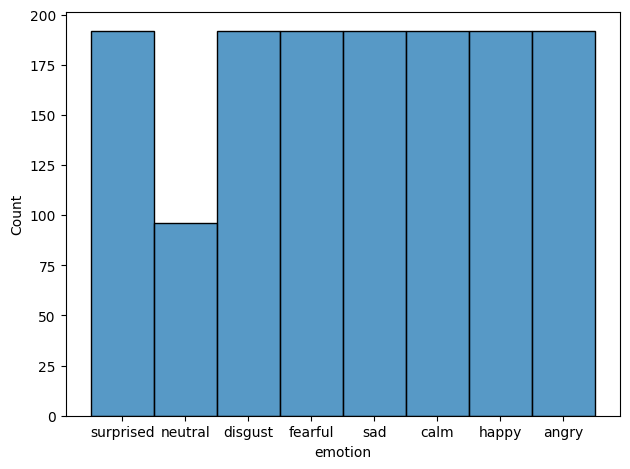

In [38]:
sns.histplot(df['emotion'].replace(num_to_emotion))
plt.tight_layout()

Определение максимальной длины записи. Не придумал ничего лучше, чем открыть каждый файл и измерить его длину 🙃
Впоследствии я понял, что Wav2Vec2.0 позволяет подавать на вход длину каждой записи в качестве аргумента. Но решил не ломать то, что и так работает.

In [39]:
MAX_WAV_LEN = 0
for i in tqdm(range(len(df))):
    wav, sr = librosa.load(df['path'][i], sr=SR)
    if len(wav) > MAX_WAV_LEN:
        MAX_WAV_LEN = len(wav)
MAX_WAV_LEN

100%|██████████| 1440/1440 [00:06<00:00, 218.74it/s]


84351

## Функции

Отрисовка матриц ошибок

In [36]:
def plot_cm(y_true, y_estim):
    cm = confusion_matrix(y_true, y_estim)
    plt.figure(figsize=(8, 6))
    cm = pd.DataFrame(
        cm, index=[v for v in num_to_emotion.values()],
        columns=[v for v in num_to_emotion.values()]
    )
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

Подготовка обучающего датасета с разбиением на тренировочный и валидационный. `X` - сырые записи в виде `torch.Tensor`, `y` - таргеты. Разбиение ведётся по актёрам, что позволяет проверять на валидации инвариантность модели при изменении голоса. Идея разбиения взята из работы: [https://paperswithcode.com/paper/a-proposal-for-multimodal-emotion-recognition](http://) \
Успел поработать только с одним из пяти фолдов. Для более точной оценки метрик качества хорошо бы провести кросс-валидацию.

In [40]:
def five_fold(dataframe, fold=0):
    
    n = len(dataframe)
    folds = [
        [2, 5, 14, 15, 16],
        [3, 6, 7, 13, 18],
        [10, 11, 12, 19, 20],
        [8, 17, 21, 23, 24],
        [1, 4, 9, 22]
    ]
    
    mask = dataframe['actor_num'].isin(folds[fold])
    X = torch.zeros((n, MAX_WAV_LEN))
    for i in tqdm(range(n)):
        wav, _ = librosa.load(dataframe['path'][i], sr=SR)
        X[i, :len(wav)] = torch.Tensor(wav)
        
    y = torch.tensor(dataframe['emotion'])
    
    return X[~mask], X[mask], y[~mask], y[mask]

Подготовка обучающего датасета с разбиением на тренировочный и валидационный. `X` - Мел-кепстральные коэффициенты в виде `torch.Tensor`, `y` - таргеты.

In [41]:
def five_fold_mfcc(dataframe, fold=0):
    
    n = len(dataframe)
    n_mfcc = 40
    folds = [
        [2, 5, 14, 15, 16],
        [3, 6, 7, 13, 18],
        [10, 11, 12, 19, 20],
        [8, 17, 21, 23, 24],
        [1, 4, 9, 22]
    ]
    
    mask = dataframe['actor_num'].isin(folds[fold])
    X = torch.zeros((n, n_mfcc))
    for i in tqdm(range(n)):
        wav, _ = librosa.load(dataframe['path'][i], sr=SR)
        mfcc = np.mean(librosa.feature.mfcc(y=wav, sr=SR, n_mfcc=n_mfcc).T, axis=0) 
        X[i] = torch.Tensor(mfcc)
    y = torch.tensor(dataframe['emotion'])
    
    return X[~mask], X[mask], y[~mask], y[mask]

Подготовка обучающего датасета с разбиением на тренировочный и валидационный. `X` - акустические фичи eGeMAPS в виде `torch.Tensor`, `y` - таргеты.

In [42]:
def five_fold_smile(dataframe, fold=0):
    
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    
    n = len(dataframe)
    n_features = len(smile.feature_names)
    folds = [
        [2, 5, 14, 15, 16],
        [3, 6, 7, 13, 18],
        [10, 11, 12, 19, 20],
        [8, 17, 21, 23, 24],
        [1, 4, 9, 22]
    ]
    
    mask = dataframe['actor_num'].isin(folds[fold])
    X = torch.zeros((n, n_features))
    for i in tqdm(range(n)):
        wav, _ = librosa.load(dataframe['path'][i], sr=SR)
        features = smile.process_signal(wav, SR).values.squeeze()
        X[i] = torch.Tensor(features)
    y = torch.tensor(dataframe['emotion'])
    
    return X[~mask], X[mask], y[~mask], y[mask]

Библиотека `audiomentations` позволяет удобно производить аугментацию обучающей выборки: растягивать и обрезать запись, накладывать фоновый шум и менять высоту звуков \
Идея функции ниже заключалась в наработке обучающих объектов, в которых голоса авторов были бы произвольно сдвинуты в пределах от -2 до 2 тонов, что позволило бы сделать модель более устойчивой к разным голосам 

In [43]:
def train_augmentation(x, n_times=5):
    augment = PitchShift(min_semitones=-2, max_semitones=2, p=1)
    x_new = torch.zeros((x.shape[0] * n_times, x.shape[1]))
    for i in tqdm(range(x.shape[0])):
        for j in range(n_times):
            x_new[i * n_times + j] = torch.Tensor(augment(x[i].numpy(), sample_rate=SR))
    return x_new

# Моя реализация

## версия 1 (fe_vgg_wav2emo)

Модель работает следующим образом:
* Feature extractor модели wav2vec2.0 извлекает аудиоэмбеддинги из сырых данных
* Признаки подаются на вход свёрточной нейронной сети в виде карт признаков
* Архитектура близкая к VGG-16 работает с полученными представлениями, как с изображениями
* На выходе модели логиты классов эмоций

Получение обучающей и валидационной выборки

In [44]:
X_train, X_val, y_train, y_val = five_fold(df, fold=0)

100%|██████████| 1440/1440 [00:05<00:00, 274.07it/s]


Незавершённый эксперимент с аугментацией

In [45]:
#X_new = train_augmentation(X_train, n_times=4)
#y_new = y_train.repeat_interleave(4)

Воспроизведение случайного примера обучающей выборки

In [46]:
k = np.random.randint(0, len(X_train))
print(num_to_emotion[int(y_train[k])])
Audio(X_train[k], rate=SR)

disgust


Подгрузка готового пайплайна модели Wav2Vec2.0 \
Под имеющиеся вычислительные ресурсы была выбрана базовая конфигурация

In [47]:
bundle = torchaudio.pipelines.WAV2VEC2_BASE
wav2vec2 = bundle.get_model()

Реализация `FeatureExtractor` под свою реализацию модели \
Решил извлекать все 12 признаковых представлений из промежуточных слоёв трансформера и затем работать с ними как с картами признаков в задачах CV

In [48]:
class FeatureExtractor(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.w2v2 = wav2vec2
    
    def forward(self, X: torch.Tensor):
        X, _ = self.w2v2.extract_features(X)
        batch_size, repr_num = X[0].shape[0], len(X)
        height, width = X[0].shape[-2], X[0].shape[-1]
        return torch.cat(X, dim=1).reshape(batch_size, repr_num, height, width)

Свёрточные блоки архитектуры VGG

In [49]:
class DoubleConv(nn.Module):
    '''
    (convolution => [BN] => ReLU) * 2 => Pooling
    '''

    def __init__(self, in_channels: int, out_channels: int, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(3)
        )

    def forward(self, x: torch.Tensor):
        return self.double_conv(x)

class TripleConv(nn.Module):
    '''
    (convolution => [BN] => ReLU) * 3 => Pooling
    '''

    def __init__(self, in_channels: int, out_channels: int, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(3)
        )

    def forward(self, x: torch.Tensor):
        return self.triple_conv(x)

Часть модели, переводящая эмбеддинги в классы эмоций. Стандартная VGG архитектура с изменёнными гиперпараметрами слоёв и добавлением `Dropout` для регуляризации модели

In [51]:
class EmbeddingToEmotion(nn.Module):
    def __init__(self):
        super(EmbeddingToEmotion, self).__init__()
        
        self.conv_layers = nn.Sequential(
            DoubleConv(12, 24),
            DoubleConv(24, 48),
            TripleConv(48, 96),
            TripleConv(96, 192),
        )
        
        self.lin_layers = nn.Sequential(
            nn.Linear(5184, 64),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(64, 8)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.lin_layers(x)
        return x

In [52]:
class TorchDataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return(len(self.x))
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

Сборка модели и замораживание слоёв `FeatureExtractor`

In [53]:
fe = FeatureExtractor()
vec2emotion = EmbeddingToEmotion()
model = nn.Sequential(fe, vec2emotion)

for i, child in enumerate(model.children()):
    if i == 0:
        for param in child.parameters():
            param.requires_grad = False
            
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Стандартный для задачи классификации `CrossEntropyLoss` и стандартный оптимайзер `Adam`. Методом проб и ошибок найден наиболее подходящий `learning_rate = 1e-5`. Использование `lr_scheduler` к заметным улучшениям не привело

In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50])
loss_function = torch.nn.CrossEntropyLoss()
train_dataloader = torch.utils.data.DataLoader(TorchDataset(X_train, y_train), batch_size=25, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(TorchDataset(X_val, y_val), batch_size=25)

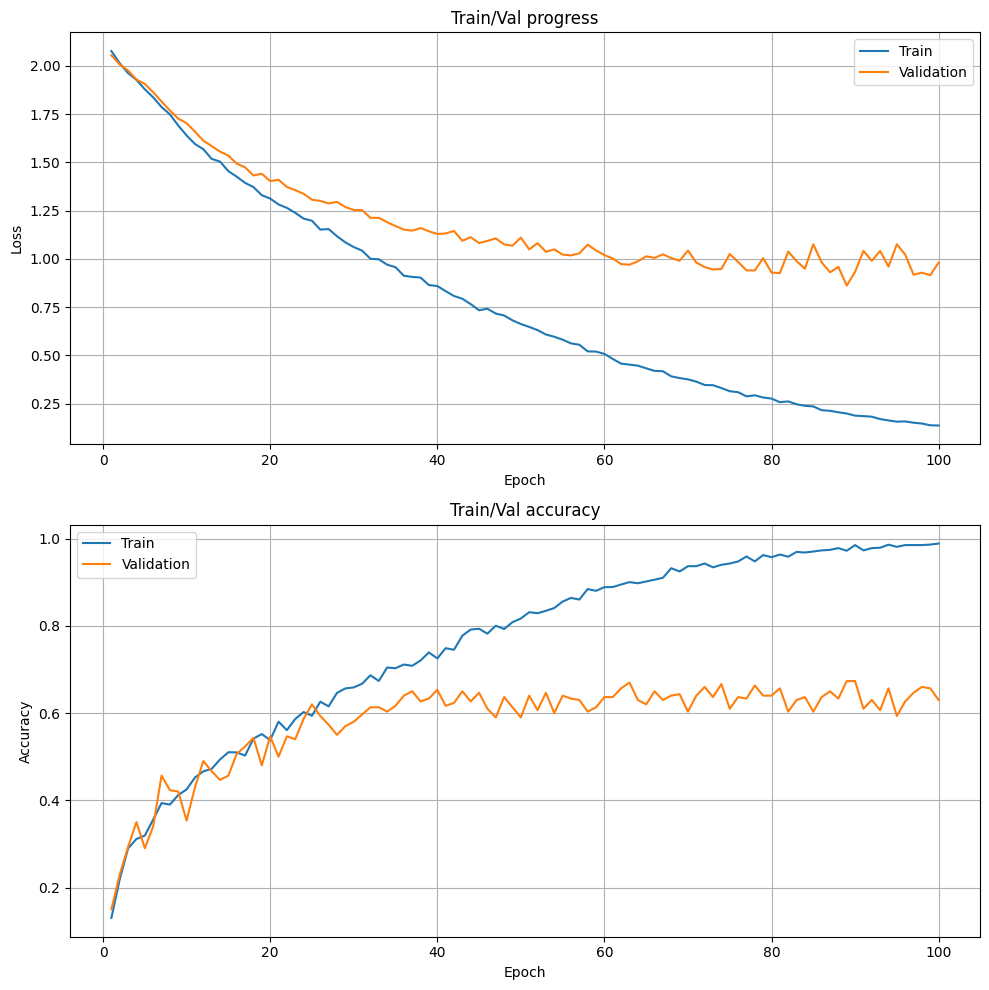

100%|██████████| 100/100 [45:50<00:00, 27.50s/it]

Epoch 100
Train Loss = 0.13739, Val Loss = 0.98105
Train Accuracy = 98.87%, Val Accuracy = 63.00%



In [55]:
epochs = 100
# Для отслеживания прогресса модели
loss_dict = {'train': [], 'val': []}
accuracy_dict = {'train': [], 'val': []}
best_state = None

for i in tqdm(range(epochs)):
    
    train_loss = val_loss = 0
    train_accuracy = val_accuracy = 0
    
    # Обучение
    model.train()
    for train_batch in train_dataloader:
        optimizer.zero_grad()
        X, y = train_batch
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        train_loss += loss.item() / len(train_dataloader)
        y_pred = torch.argmax(y_pred, dim=1)
        train_accuracy += accuracy_score(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy()) / len(train_dataloader)
    
    # Валидация
    model.eval()
    with torch.no_grad():
        for val_batch in val_dataloader:
            X, y = val_batch
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_function(y_pred, y)
            val_loss += loss.item() / len(val_dataloader)
            y_pred = torch.argmax(y_pred, dim=1)
            val_accuracy += accuracy_score(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy()) / len(val_dataloader)
                              
    #lr_scheduler.step()

    # Cохрание состояния модели, соответствующего минимальному валидационному лоссу
    if i > 0 and val_loss < min(loss_dict['val']):
        best_state = deepcopy(model.state_dict())
    
    # Запись прогресса
    loss_dict['train'].append(train_loss)
    loss_dict['val'].append(val_loss)
    accuracy_dict['train'].append(train_accuracy)
    accuracy_dict['val'].append(val_accuracy)
    
    clear_output(wait=True)
    plt.figure(figsize=(10, 10))
    
    # Отрисовка изменений лосса
    plt.subplot(2, 2, (1, 2))
    plt.title('Train/Val progress')
    plt.plot(range(1, i + 2), loss_dict['train'], label='Train')
    plt.plot(range(1, i + 2), loss_dict['val'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    
    # Отрисовка изменений accuracy
    plt.subplot(2, 2, (3, 4))
    plt.title('Train/Val accuracy')
    plt.plot(range(1, i + 2), accuracy_dict['train'], label='Train')
    plt.plot(range(1, i + 2), accuracy_dict['val'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
                              
    plt.tight_layout()
    plt.show()
    
    # Вывод прогресса для текущей эпохи
    print(f'Epoch {i + 1}')
    print(f'Train Loss = {train_loss:.5f}, Val Loss = {val_loss:.5f}')
    print(f'Train Accuracy = {(float(train_accuracy) * 100):.2f}%, Val Accuracy = {(float(val_accuracy) * 100):.2f}%')
    print()

Сохранение весов лучшего состояния

In [58]:
#torch.save(best_state, '/kaggle/working/fe_vgg_wav2emo_dropout100.pt')

Предсказания модели для лучшего состояния

In [60]:
test_dataloader = torch.utils.data.DataLoader(TorchDataset(X_val, y_val))
y_predicted = torch.zeros_like(y_val)
with torch.no_grad():
    model.load_state_dict(best_state)
    for i, test_batch in enumerate(test_dataloader):
        X, y = test_batch
        X, y = X.to(device), y.to(device)        
        y_pred = model(X).cpu()
        y_predicted[i] = torch.argmax(y_pred)

Расчёт метрик

In [61]:
print(classification_report(y_val, y_predicted))

              precision    recall  f1-score   support

           0       0.58      0.55      0.56        20
           1       0.77      0.85      0.81        40
           2       0.72      0.45      0.55        40
           3       0.59      0.47      0.53        40
           4       0.73      0.88      0.80        40
           5       0.81      0.62      0.70        40
           6       0.60      0.72      0.66        40
           7       0.58      0.78      0.67        40

    accuracy                           0.67       300
   macro avg       0.67      0.67      0.66       300
weighted avg       0.68      0.67      0.67       300



Построение матрицы ошибок

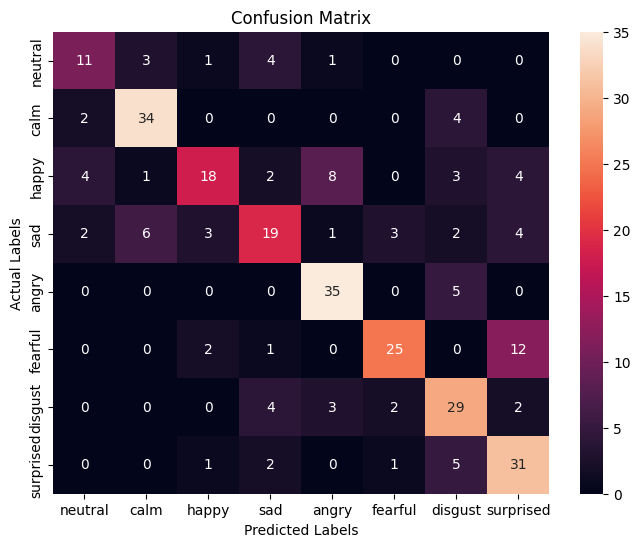

In [62]:
plot_cm(y_val, y_predicted)

Больше всего ошибок между парами angry-happy (0+8), disgust-angry (3+5), fearful-surprised(1+12), что может быть обусловлено недостатком обучающих примеров. Из полученных результатов можно сделать вывод, что более яркие эмоции различимы хуже. Это может быть связано с уникальностью интонаций каждого из актёров

## версия 2 (fe_vgg_eGeMAPS_wav2emo)

Данная реализация отличается лишь тем, что, помимо использования аудиоэмбеддингов, здесь применяются аудио фичи eGeMAPS \
Во многих местах код дублирует уже написанный ранее, поэтому ячейки желательно запускать последовательно

In [70]:
X_train, X_val, y_train, y_val = five_fold(df, fold=0)
X_train_smile, X_val_smile, y_train_smile, y_val_smile = five_fold_smile(df, fold=0)

100%|██████████| 1440/1440 [02:47<00:00,  8.60it/s]


In [71]:
bundle = torchaudio.pipelines.WAV2VEC2_BASE
wav2vec2 = bundle.get_model()

In [72]:
class FeatureExtractorEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.w2v2 = wav2vec2
    
    def forward(self, X: torch.Tensor):
        X, _ = self.w2v2.extract_features(X)
        batch_size, repr_num = X[0].shape[0], len(X)
        height, width = X[0].shape[-2], X[0].shape[-1]
        return X

In [73]:
class DoubleConv(nn.Module):
    '''
    (convolution => [BN] => ReLU) * 2 => Pooling
    '''

    def __init__(self, in_channels: int, out_channels: int, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(3)
        )

    def forward(self, x: torch.Tensor):
        return self.double_conv(x)

class TripleConv(nn.Module):
    '''
    (convolution => [BN] => ReLU) * 3 => Pooling
    '''

    def __init__(self, in_channels: int, out_channels: int, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(3)
        )

    def forward(self, x: torch.Tensor):
        return self.triple_conv(x)

In [74]:
class EmbeddingToEmotion(nn.Module):
    def __init__(self):
        super(EmbeddingToEmotion, self).__init__()
        
        self.conv_layers = nn.Sequential(
            DoubleConv(12, 24),
            DoubleConv(24, 48),
            TripleConv(48, 96),
            TripleConv(96, 192),
        )
        
        self.lin_layer = nn.Sequential(
            nn.Linear(5184, 64),
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.lin_layer(x)
        return x

Отдельная ветка модели, получающая на вход аудио фичи

In [75]:
class SmileModel(nn.Module):
    def __init__(self):
        super(SmileModel, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(88, 64),
            nn.ReLU(),
        )
        
    def forward(self, x):
        x = self.layer(x)
        return x

Соединение моделей

In [76]:
class CombinedModel(nn.Module):
    def __init__(self, modelA, modelB):
        super(CombinedModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.out_layers = nn.Sequential(
            nn.Linear(64 + 64, 64),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(64, 8)
        )
        
    def forward(self, x, x_smile):
        x = self.modelA(x)
        x_smile = self.modelB(x_smile)
        x = torch.cat((x, x_smile), dim=1)
        x = self.out_layers(x)
        return x

In [77]:
class TorchDataset:
    def __init__(self, x, x_smile, y):
        self.x = torch.Tensor(x).to(torch.float32)
        self.x_smile = torch.Tensor(x_smile).to(torch.float32)
        self.y = torch.Tensor(y)
        
    def __len__(self):
        return(len(self.x))
    
    def __getitem__(self, i):
        return self.x[i], self.x_smile[i], self.y[i]

In [78]:
vec2emotion = EmbeddingToEmotion()
fe = FeatureExtractor()
model1 = nn.Sequential(fe, vec2emotion)

for i, child in enumerate(model1.children()):
    if i == 0:
        for param in child.parameters():
            param.requires_grad = False
            
model2 = SmileModel()
model = CombinedModel(model1, model2)
            
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Нормализация признаков eGeMAPS

In [79]:
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train_smile)
X_val_scal = scaler.fit_transform(X_val_smile)

In [80]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50])
loss_function = torch.nn.CrossEntropyLoss()
train_dataloader = torch.utils.data.DataLoader(TorchDataset(X_train, X_train_scal, y_train), batch_size=25, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(TorchDataset(X_val, X_val_scal, y_val), batch_size=25)

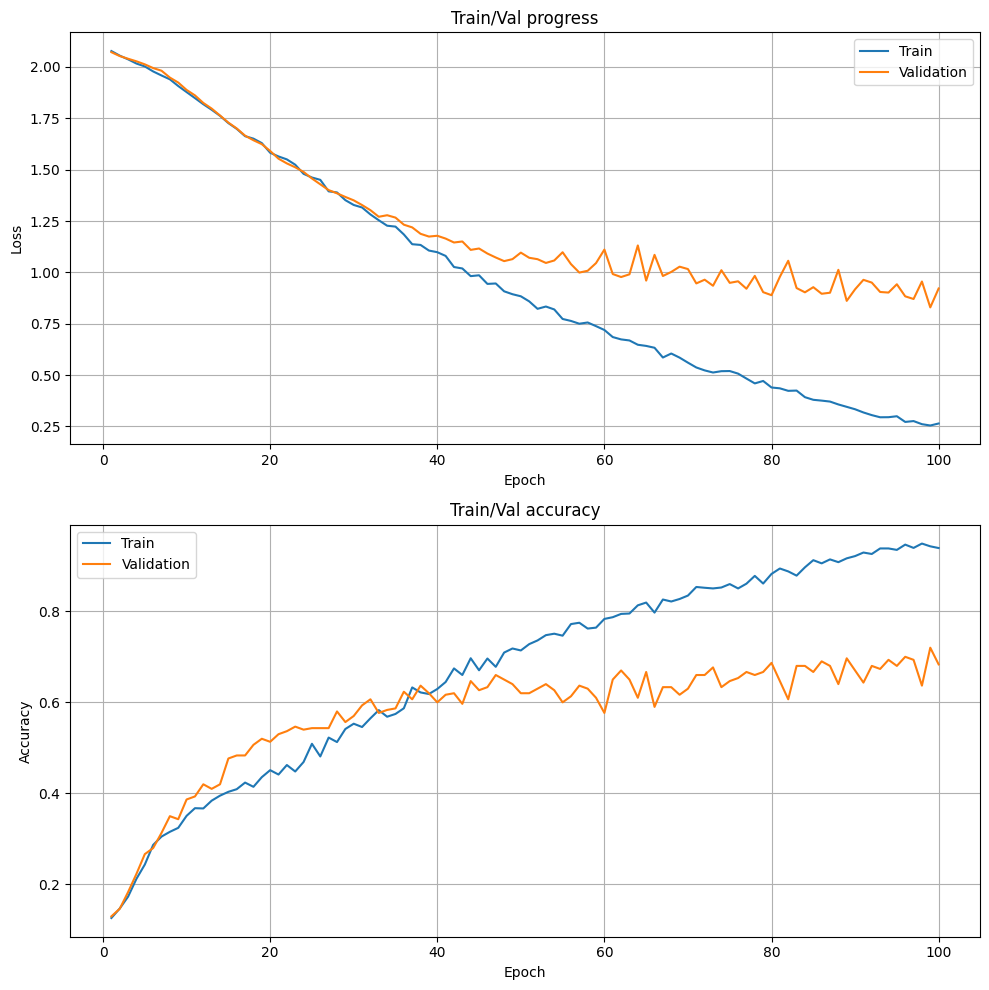

100%|██████████| 100/100 [45:53<00:00, 27.54s/it]

Epoch 100
Train Loss = 0.26462, Val Loss = 0.92177
Train Accuracy = 93.88%, Val Accuracy = 68.33%



In [81]:
epochs = 100
loss_dict = {'train': [], 'val': []}
accuracy_dict = {'train': [], 'val': []}
best_state2 = None

for i in tqdm(range(epochs)):
    
    train_loss = val_loss = 0
    train_accuracy = val_accuracy = 0
    
    model.train()
    for train_batch in train_dataloader:
        optimizer.zero_grad()
        X, X_sm, y = train_batch
        X, X_sm, y = X.to(device), X_sm.to(device), y.to(device)
        
        y_pred = model(X, X_sm)
        loss = loss_function(y_pred, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        train_loss += loss.item() / len(train_dataloader)
        y_pred = torch.argmax(y_pred, dim=1)
        train_accuracy += accuracy_score(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy()) / len(train_dataloader)
            
    model.eval()
    with torch.no_grad():
        for val_batch in val_dataloader:
            X, X_sm, y = val_batch
            X, X_sm, y = X.to(device), X_sm.to(device), y.to(device)

            y_pred = model(X, X_sm)
            loss = loss_function(y_pred, y)
            val_loss += loss.item() / len(val_dataloader)
            y_pred = torch.argmax(y_pred, dim=1)
            val_accuracy += accuracy_score(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy()) / len(val_dataloader)
                              
    #lr_scheduler.step()

    if i > 0 and val_loss < min(loss_dict['val']):
            print(f'Epoch {i + 1} - new best loss {val_loss}')
            best_state2 = deepcopy(model.state_dict())
                              
    loss_dict['train'].append(train_loss)
    loss_dict['val'].append(val_loss)
    accuracy_dict['train'].append(train_accuracy)
    accuracy_dict['val'].append(val_accuracy)
    
    clear_output(wait=True)
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, (1, 2))
    plt.title('Train/Val progress')
    plt.plot(range(1, i + 2), loss_dict['train'], label='Train')
    plt.plot(range(1, i + 2), loss_dict['val'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
                              
    plt.subplot(2, 2, (3, 4))
    plt.title('Train/Val accuracy')
    plt.plot(range(1, i + 2), accuracy_dict['train'], label='Train')
    plt.plot(range(1, i + 2), accuracy_dict['val'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
                              
    plt.tight_layout()
    plt.show()
    
    print(f'Epoch {i + 1}')
    print(f'Train Loss = {train_loss:.5f}, Val Loss = {val_loss:.5f}')
    print(f'Train Accuracy = {(float(train_accuracy) * 100):.2f}%, Val Accuracy = {(float(val_accuracy) * 100):.2f}%')
    print()

In [83]:
#torch.save(best_state2, '/kaggle/working/fe_vgg_eGeMAPS_wav2emo_dropout100.pt')

In [84]:
test_dataloader = torch.utils.data.DataLoader(TorchDataset(X_val, X_val_scal, y_val))
model.load_state_dict(best_state2)
model.eval()
y_predicted = torch.zeros_like(y_val)
with torch.no_grad():
    for i, test_batch in enumerate(test_dataloader):
        X, X_sm, y = test_batch
        X, X_sm, y = X.to(device), X_sm.to(device), y.to(device)        
        y_pred = model(X, X_sm).cpu()
        y_predicted[i] = torch.argmax(y_pred)

              precision    recall  f1-score   support

           0       0.58      0.75      0.65        20
           1       0.79      0.78      0.78        40
           2       0.76      0.78      0.77        40
           3       0.70      0.35      0.47        40
           4       0.79      0.95      0.86        40
           5       0.61      0.70      0.65        40
           6       0.78      0.70      0.74        40
           7       0.70      0.78      0.74        40

    accuracy                           0.72       300
   macro avg       0.71      0.72      0.71       300
weighted avg       0.72      0.72      0.71       300



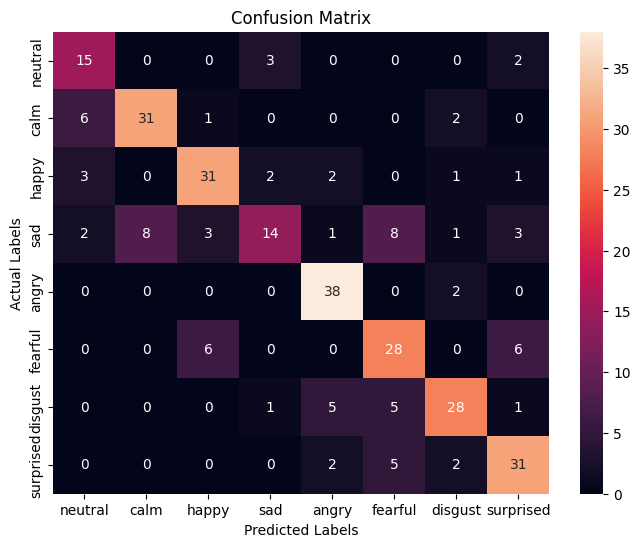

In [85]:
print(classification_report(y_val, y_predicted))
plot_cm(y_val, y_predicted)

Результат получается лучше, чем при использовании одних эмбеддингов. Пара с наибольшим числом ошибок вновь fearful-surprised (5+6). Это можно объяснить тем, что пара выражает два разных проявления одной более общей эмоции - удивление (в негативном и позитивном ключе соответственно).

Согласно работе [https://www.researchgate.net/publication/354945580_An_End-To-End_Emotion_Recognition_Framework_Based_on_Temporal_Aggregation_of_Multimodal_Information](http://)
Human-Performance (по accuracy) на датасете RAVDESS (при использовании и аудио, и видео данных) составляет 80%. Предложенной в данном ноутбуке модели есть куда расти! Осталось попасть в лабораторию...

# Mel-frequency cepstral coefficients (MFCC)

Использование Мел-кепстральных коэффициентов в качестве фичей (довольно распространённая практика до появления моделей как Wav2Vec)

In [40]:
X_train, X_val, y_train, y_val = five_fold_mfcc(df, fold=0)

100%|██████████| 1440/1440 [00:30<00:00, 47.40it/s]


              precision    recall  f1-score   support

           0       0.18      0.25      0.21        20
           1       0.19      0.10      0.13        40
           2       0.14      0.10      0.12        40
           3       0.16      0.20      0.18        40
           4       0.42      0.45      0.43        40
           5       0.33      0.35      0.34        40
           6       0.14      0.15      0.14        40
           7       0.40      0.42      0.41        40

    accuracy                           0.25       300
   macro avg       0.24      0.25      0.25       300
weighted avg       0.25      0.25      0.25       300



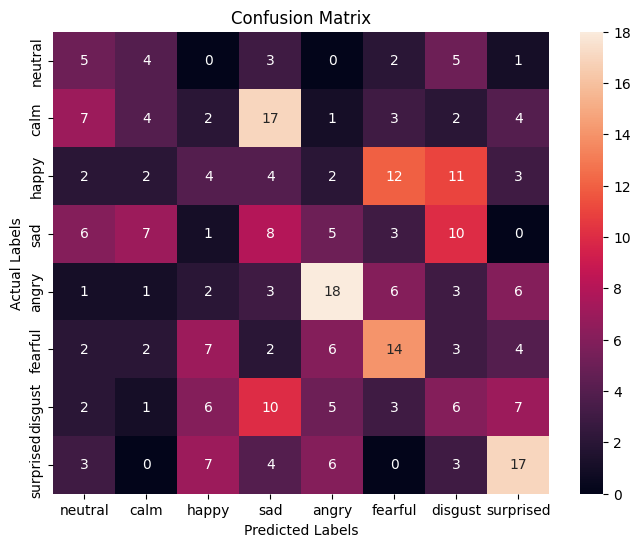

In [41]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_val)
print(classification_report(y_val, y_pred))
plot_cm(y_val, y_pred)

Дерево угадывает немногим лучше, чем dummy-classifier. При взгляде на матрицу ошибок есть ощущение, что модель чуть лучше различает неяркие (neutral, calm) и яркие (остальные) эмоции. 

              precision    recall  f1-score   support

           0       0.14      0.05      0.07        20
           1       0.44      0.42      0.43        40
           2       0.31      0.23      0.26        40
           3       0.16      0.17      0.17        40
           4       0.76      0.62      0.68        40
           5       0.73      0.28      0.40        40
           6       0.29      0.45      0.35        40
           7       0.39      0.70      0.50        40

    accuracy                           0.39       300
   macro avg       0.40      0.37      0.36       300
weighted avg       0.42      0.39      0.38       300



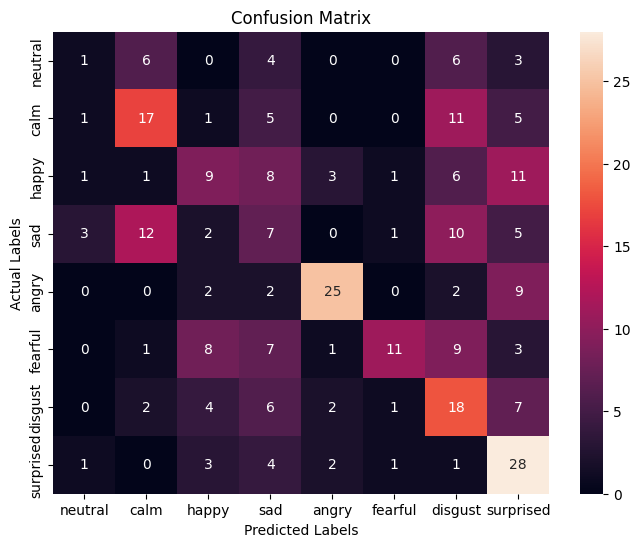

In [42]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_val)
print(classification_report(y_val, y_pred))
plot_cm(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.09      0.05      0.06        20
           1       0.42      0.28      0.33        40
           2       0.40      0.42      0.41        40
           3       0.31      0.20      0.24        40
           4       0.71      0.75      0.73        40
           5       0.64      0.23      0.33        40
           6       0.33      0.50      0.40        40
           7       0.36      0.70      0.47        40

    accuracy                           0.41       300
   macro avg       0.41      0.39      0.37       300
weighted avg       0.43      0.41      0.39       300



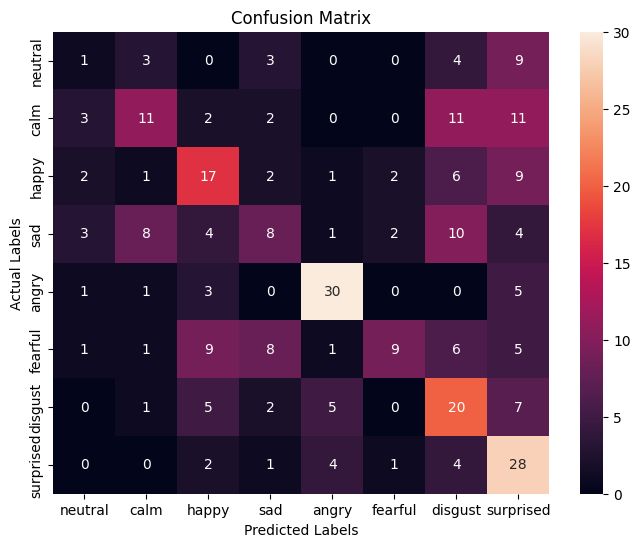

In [43]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_val)
print(classification_report(y_val, y_pred))
plot_cm(y_val, y_pred)

При более детальном анализе результатов последних две моделей, а затем и предыдущих можно обратить внимание на то, что злоба в среднем распознается лучше, чем другие эмоции. Стоит внимательнее изучить спектрограммы эмоций

# eGeMAPS

Использование набора аудиофичей eGeMAPS

In [12]:
X_train, X_val, y_train, y_val = five_fold_smile(df, fold=0)

100%|██████████| 1440/1440 [03:05<00:00,  7.78it/s]


In [13]:
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train)
X_val_scal = scaler.fit_transform(X_val)

              precision    recall  f1-score   support

           0       0.58      0.35      0.44        20
           1       0.71      0.72      0.72        40
           2       0.46      0.60      0.52        40
           3       0.34      0.33      0.33        40
           4       0.58      0.62      0.60        40
           5       0.51      0.50      0.51        40
           6       0.53      0.42      0.47        40
           7       0.74      0.80      0.77        40

    accuracy                           0.56       300
   macro avg       0.56      0.54      0.55       300
weighted avg       0.56      0.56      0.55       300



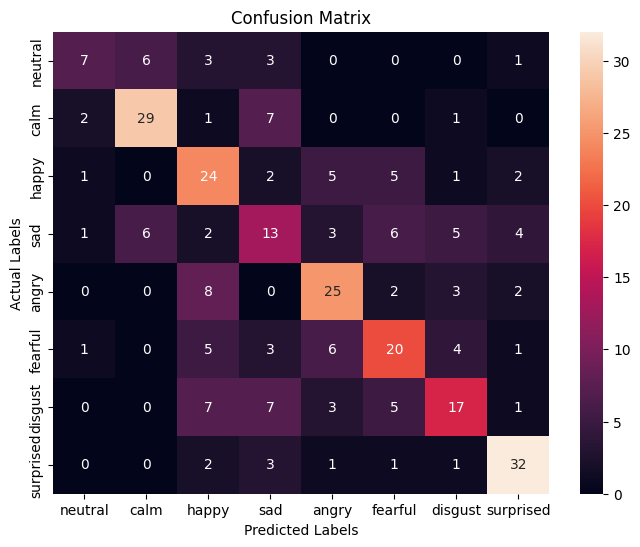

In [14]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_scal, y_train)
y_pred = xgb_clf.predict(X_val_scal)
print(classification_report(y_val, y_pred))
plot_cm(y_val, y_pred)

Набор признаков eGeMAPS значительно повышает качество распознавания эмоций относительно MFCC фичей. Но модель обученная таким образом не достигает уровня распознавания, как у моделей, использующих аудиоэмбеддинги

# From HuggingFace

Я попробовал использовать предобученную модель с Hugging Face, но она продемонстрировала слабый результат. Возможно, мой препроцессинг данных (расширение всех файлов до максимальной длины) отличался от проведённого автором, либо данная модель сильно переобучилась под исходный датасет. 

In [10]:
X_train, X_val, y_train, y_val = five_fold(df, fold=0)

100%|██████████| 1440/1440 [00:07<00:00, 195.90it/s]


In [37]:
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained("Wiam/wav2vec2-base-finetuned-ravdess")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_val = X_val.to(device)

In [13]:
def predict(X):
    return torch.argmax(model(X).logits)

In [14]:
y_pred = torch.zeros_like(y_val)
for i in tqdm(range(len(y_val))):
    y_pred[i] = predict(X_val[i].reshape(1, -1))

100%|██████████| 300/300 [11:49<00:00,  2.36s/it]


In [15]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.20      0.20        20
           1       1.00      0.17      0.30        40
           2       0.30      0.55      0.39        40
           3       0.36      0.20      0.26        40
           4       0.47      0.97      0.63        40
           5       0.65      0.42      0.52        40
           6       0.93      0.65      0.76        40
           7       0.80      0.80      0.80        40

    accuracy                           0.52       300
   macro avg       0.59      0.50      0.48       300
weighted avg       0.62      0.52      0.50       300



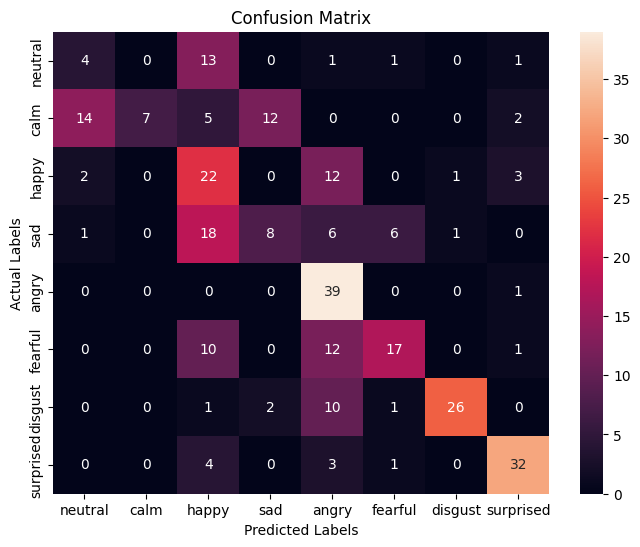

In [16]:
plot_cm(y_val, y_pred)

Но recall злости потрясающий...

# Запись предсказаний для тестового датасета

Использовал схожую схему, что и при препроцессинге тренировочных данных. Здесь я был вынужден так же расширять (в паре случаев обрезать) записи до прежней максимальной длины, что является ограничением предложенной мною модели

In [86]:
test_path = '/kaggle/input/test-emotion-dataset/original'
test_directory_list = os.listdir(test_path)
test_info = {
    'path': []
}

for file in test_directory_list:
    test_info['path'].append(test_path + '/' + file)
        
test_df = pd.DataFrame(test_info)
test_df.head(5)

,path
0,/kaggle/input/test-emotion-dataset/original/5_...
1,/kaggle/input/test-emotion-dataset/original/6_...
2,/kaggle/input/test-emotion-dataset/original/8_...
3,/kaggle/input/test-emotion-dataset/original/3_...
4,/kaggle/input/test-emotion-dataset/original/2_...


In [87]:
def test_load(dataframe, smile_option=False):
    
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )   
    
    n = len(dataframe)
    n_features = len(smile.feature_names)
    
    X = torch.zeros((n, MAX_WAV_LEN))
    X_smile = torch.zeros((n, n_features))
    
    for i in tqdm(range(n)):
        wav, _ = librosa.load(dataframe['path'][i], sr=SR)
        X[i, :len(wav)] = torch.Tensor(wav)[:MAX_WAV_LEN]
        if smile_option:
            features = smile.process_signal(wav, SR).values.squeeze()
            X_smile[i] = torch.Tensor(features)
    
    if not smile_option:
        return X
    else:
        return X, X_smile

Загрузить тестовые записи можно и для первой, и для второй версии модели

In [88]:
X_test, X_smile_test = test_load(test_df, smile_option=True)

100%|██████████| 1550/1550 [02:14<00:00, 11.51it/s]


Этот код приходится модифицировать под конкретную модель

Предсказание вероятностей

In [92]:
y_pred_test = torch.zeros((len(X_test), 8))
model.load_state_dict(best_state2)
with torch.no_grad():
    for i in tqdm(range(len(X_test))):
        x, x_sm = X_test[i:i+1], X_smile_test[i:i+1]
        x_sm = torch.Tensor(scaler.transform(x_sm))
        x, x_sm = x.to(device), x_sm.to(device)     
        y_pred = model(x, x_sm).cpu()
        y_pred_test[i] = torch.nn.functional.softmax(y_pred)

100%|██████████| 1550/1550 [00:37<00:00, 41.04it/s]


Формирование выходного датафрейма

In [93]:
out = pd.DataFrame()
out['file_id'] = test_df['path'].str.extract('/([\w]+)\.wav') + '.wav'
out[['0' + str(i) for i in range(1, 9)]] = pd.DataFrame(y_pred_test)
out.head()

,file_id,01,02,03,04,05,06,07,08
0,5_38_0.wav,0.029871,0.240462,0.007787,0.036709,0.163042,0.170712,0.328342,0.023074
1,6_47_0.wav,0.144673,0.129008,0.032706,0.061842,0.030157,0.261123,0.039755,0.300737
2,8_31_0.wav,0.136585,0.494633,0.056483,0.179870,0.060128,0.030983,0.032583,0.008734
3,3_49_4.wav,0.069286,0.927909,0.000303,0.000278,0.001536,0.000114,0.000011,0.000563
4,2_48_4.wav,0.021622,0.009854,0.209743,0.012252,0.501173,0.110803,0.007927,0.126626


In [105]:
out.sample(25)

,file_id,01,02,03,04,05,06,07,08
1032,7_35_2.wav,0.138099,0.778014,0.007789,0.047940,0.007221,0.006722,0.002990,0.011226
958,2_32_3.wav,0.404464,0.153531,0.137878,0.077371,0.062695,0.049093,0.006352,0.108616
960,9_40_2.wav,0.031916,0.037081,0.004584,0.074920,0.143633,0.051880,0.582819,0.073167
294,1_35_3.wav,0.036829,0.757787,0.003207,0.162117,0.003792,0.019779,0.012021,0.004467
1182,4_37_3.wav,0.462487,0.154503,0.060452,0.034581,0.007179,0.030735,0.003269,0.246794
1252,7_34_3.wav,0.146187,0.677188,0.031246,0.114534,0.015240,0.004904,0.001401,0.009300
1308,9_34_2.wav,0.477089,0.293869,0.067222,0.041346,0.028627,0.018607,0.005703,0.067537
1123,1_28_4.wav,0.308824,0.114366,0.133241,0.038902,0.172893,0.064876,0.007311,0.159587
1414,9_22_3.wav,0.102266,0.841567,0.006116,0.036371,0.005628,0.003274,0.001136,0.003640
674,5_23_2.wav,0.177233,0.042683,0.058326,0.013701,0.025466,0.235426,0.008709,0.438457


Запись и попытка "ручной" оценки качества модели на тестовых данных

In [94]:
out.to_csv('/kaggle/working/pred3.csv', index=False, sep='|')

In [108]:
www, _ = librosa.load('/kaggle/input/test-emotion-dataset/original/1_35_3.wav', sr=SR)
Audio(www, rate=SR)